In [2]:
!pip install hdbscan
!pip install optuna
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Step 1: Load the dataset
data = pd.read_csv('Encoded_Cybersecurity_Data.csv')

# Drop 'User Information' column from the dataset
data = data.drop(columns=['User Information'], errors='ignore')

# SPLIT

In [4]:
from sklearn.model_selection import train_test_split

# Step 2: Define features and target
X = data.drop(columns=['Attack Type'])  # Drop the target column ('Attack Type')
y = data['Attack Type']  # Target column

# Step 3: Split the data into train, test, and validation sets
# First, split data into train + validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then, split train + validation into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Verify the shapes of the resulting sets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (24000, 41), (24000,)
Validation set: (8000, 41), (8000,)
Test set: (8000, 41), (8000,)


uses scikit-learn’s `train_test_split` to first separate the features (all columns except `'Attack Type'`) from the target (`'Attack Type'`), then splits the data into 80% for training/validation and 20% for testing (using `stratify` for balanced classes and `random_state=42` for reproducibility), and finally divides the training/validation set into 60% training and 20% validation, printing the shapes to confirm the splits. 🚀📊


# Feature Selection with SelectKBest & f_classif 🔍

This explanation demonstrates how to select the most important features from your dataset using scikit-learn’s **SelectKBest** with the ANOVA F-value (**f_classif**) on the training data.

---

## 1. Setup & Scoring 📚

- **Imports & Setup:**  
  - Use **SelectKBest** and **f_classif** for feature evaluation, along with **pandas** for data manipulation.
- **Fitting on Training Data:**  
  - The model is fitted on the training data (`X_train`, `y_train`) to compute F-scores for all features.

---

## 2. Visualizing Feature Scores 📊

- **Extracting Scores:**  
  - The computed F-scores are stored in the model’s attribute.
  - Feature names are obtained from the dataset’s column names.
- **DataFrame Creation:**  
  - A DataFrame is created to organize and sort the features by their scores in descending order, highlighting the most important features.

---

## 3. Selecting Top Features ⭐

- **Choosing the Best:**  
  - The top 10 features are selected based on their high F-scores.
- **Subsetting Data:**  
  - The training, validation, and test sets are then filtered to include only these top features.
- **Benefit:**  
  - This selection reduces noise, simplifies the model, and can improve performance by focusing on the most significant features.

---

**Key Takeaways:**

- **SelectKBest & f_classif** rank features based on their statistical significance.
- Visualizing scores in a DataFrame makes it easy to identify which features contribute most.
- Selecting top features can enhance model performance by reducing complexity.




In [5]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Step 1: Apply SelectKBest on the Training Set
# Use f_classif to compute ANOVA F-values between features and the target
best_features = SelectKBest(score_func=f_classif, k='all')
best_features.fit(X_train, y_train)  # Use training set for feature selection

# Step 2: Get Feature Scores
feature_scores = best_features.scores_
feature_names = X_train.columns

# Create a DataFrame to visualize feature scores
feature_scores_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': feature_scores
}).sort_values(by='Score', ascending=False)

# Display the top features
print("Feature Scores:\n", feature_scores_df)

# Step 3: Select Top Features
# Example: Keep the top 10 features
top_features = feature_scores_df.head(10)['Feature'].tolist()
X_train_top_features = X_train[top_features]
X_val_top_features = X_val[top_features]
X_test_top_features = X_test[top_features]

# Display selected top features
print(f"Top Features:\n{top_features}")


Feature Scores:
                           Feature     Score
40              City_Attack_Count  3.856272
34                   Agent Family  3.847872
18                          State  2.993615
20                          month  2.600949
37                    Device Type  1.754267
25                    day_of_week  1.473876
28                  is_lunch_hour  1.344568
22                           Hour  1.334715
21                            day  1.260020
1                   Packet Length  1.204010
31         Packet Length Category  1.194932
23                    Time of Day  1.175464
27              is_business_hours  1.169703
6                 Alerts/Warnings  1.143040
33                     Used Proxy  1.076932
16        Suspicious Proxy Subnet  1.076932
8                    Action Taken  1.036918
13                     Log Source  0.997200
38               Rendering Engine  0.840638
0                        Protocol  0.818279
11                  Firewall Logs  0.640970
3              

# Clustering with HDBSCAN and PCA 🔍📊

This explanation outlines how to perform clustering using **HDBSCAN** on top-selected features and then visualize the results with **PCA**.

---

## 1. Selecting Top Features for Clustering 🏆

- **Objective:**  
  - Identify the most relevant features (excluding the target, e.g., 'Attack Type') from the training set.
- **Approach:**  
  - Use feature scores from prior analysis to select the top 5 features.
  - Subset the training data to include only these features for clustering.

---

## 2. Fine-Tuning HDBSCAN Parameters 🔧

- **HDBSCAN Overview:**  
  - A density-based clustering algorithm that can find clusters of varying shapes and sizes while handling noise.
- **Parameter Adjustments:**  
  - **min_cluster_size:** Determines the smallest allowable cluster size.
  - **min_samples:** Helps include more points in clusters and reduces noise.
  - **Metric:** Uses a specific distance metric (e.g., Euclidean) to measure similarity.
  - **cluster_selection_method:** Chooses the method for selecting clusters (e.g., 'eom' for a balance between granularity and stability).

---

## 3. Fitting HDBSCAN & Labeling Data 📌

- **Model Fitting:**  
  - Apply HDBSCAN to the training data with the selected top features.
  - Generate cluster labels that categorize each data point.
- **Data Augmentation:**  
  - Add these cluster labels as a new column to the training dataset for further analysis.

---

## 4. Analyzing & Visualizing Cluster Distribution 📈

- **Cluster Analysis:**  
  - Evaluate the distribution of the cluster labels to understand how data points are grouped.
- **Visualization:**  
  - Create a histogram of cluster labels to observe the frequency of each cluster and identify any noise points.

---

## 5. Visualizing Clusters with PCA 🎨

- **Dimensionality Reduction:**  
  - Use PCA to reduce the feature space to 2 dimensions for easier visualization.
- **Scatter Plot:**  
  - Plot the PCA-transformed data, using colors to represent different clusters.
  - This visual helps assess the separation and structure of clusters in a 2D space.

---

## 6. Preparing Validation & Test Sets for Clustering 🔄

- **Consistency in Feature Selection:**  
  - Subset both the validation and test sets to include the same top features used for training.
- **Placeholder Clusters:**  
  - Add a placeholder cluster column (e.g., setting it to -1) for these sets, which can later be updated as needed.

---

**Notes:**

- **HDBSCAN** efficiently clusters data by automatically identifying clusters and handling noise.
- Parameter tuning (like adjusting cluster size and sample inclusion) is vital for improving cluster quality.
- **PCA** simplifies high-dimensional data, allowing for intuitive 2D visualization of clusters.
- Maintaining consistent feature selection across all data splits ensures reliable analysis.




Further Improved Cluster Distribution:
 -1      1190
 0       278
 942      63
 930      63
 674      62
        ... 
 457      10
 245      10
 341      10
 153      10
 581      10
Name: count, Length: 1015, dtype: int64


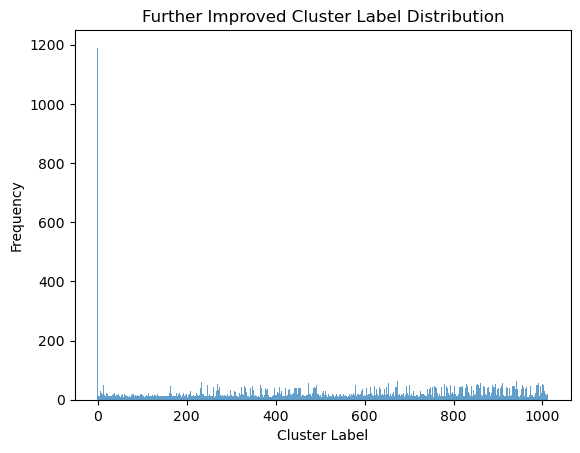

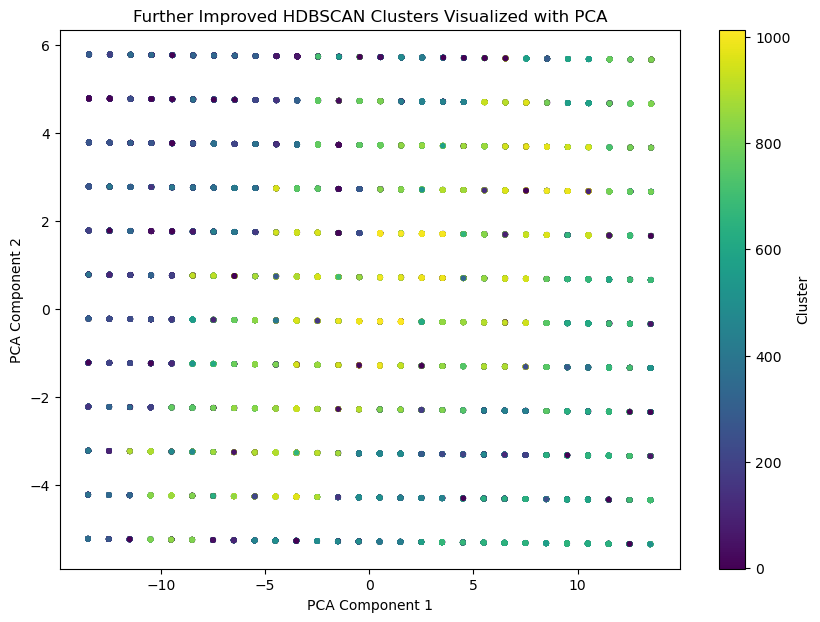

Training data with clusters:
       Protocol  Packet Length  Packet Type  Traffic Type  Malware Indicators  \
35280         2       0.919499            1             1                   1   
36618         1       0.770474            0             1                   0   
31956         1      -0.041950            0             2                   1   
30238         1      -0.022721            1             2                   0   
1346          0       1.537229            0             2                   1   

       Anomaly Scores  Alerts/Warnings  Attack Signature  Action Taken  \
35280        1.060073                0                 1             2   
36618       -1.184390                1                 0             1   
31956        0.598773                0                 0             2   
30238       -1.198253                0                 1             2   
1346         0.784194                0                 0             1   

       Severity Level  ...  Anomaly Cat

In [6]:
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Select top features for clustering (using training data only)
top_features = [f for f in feature_scores_df['Feature'].head(5).values if f != 'Attack Type']
X_train_top_features = X_train[top_features]

# Step 2: Fine-tune HDBSCAN parameters to reduce noise
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,       # Slightly smaller clusters
    min_samples=2,             # Include more points in clusters
    metric='euclidean',        # Try a different distance metric
    cluster_selection_method='eom'  # 'leaf' for more granular clusters
)

# Fit HDBSCAN on the top features
train_cluster_labels = hdbscan_model.fit_predict(X_train_top_features)

# Step 3: Add the new cluster labels to the training data
X_train_with_clusters = X_train.copy()
X_train_with_clusters['Cluster'] = train_cluster_labels

# Step 4: Analyze the new cluster distribution
cluster_distribution = pd.Series(train_cluster_labels).value_counts()
print("Further Improved Cluster Distribution:\n", cluster_distribution)

# Step 5: Visualize the cluster distribution
plt.hist(train_cluster_labels, bins=len(set(train_cluster_labels)), alpha=0.7)
plt.title('Further Improved Cluster Label Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.show()

# Step 6: Visualize clusters in PCA-reduced dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_top_features)

plt.figure(figsize=(10, 7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_cluster_labels, cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title('Further Improved HDBSCAN Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Step 7: Prepare validation and test sets
X_val_top_features = X_val[top_features]
X_test_top_features = X_test[top_features]

# Add placeholder cluster column for validation and test sets
X_val_with_clusters = X_val.copy()
X_test_with_clusters = X_test.copy()

X_val_with_clusters['Cluster'] = -1  # Placeholder for validation
X_test_with_clusters['Cluster'] = -1  # Placeholder for test

# Final Output: Display example of updated training data
print(f"Training data with clusters:\n{X_train_with_clusters.head()}")


In [7]:
import pickle
from IPython.display import FileLink

# Save the trained cluster models dictionary
with open('hdbscan_2_model.pkl', 'wb') as file:
    pickle.dump(train_cluster_labels, file)
print("Pickle file saved: hdbscan_2_model.pkl")

# Generate a download link for the pickle file
FileLink('hdbscan_2_model.pkl')

Pickle file saved: hdbscan_2_model.pkl


C:\Users\antho\OneDrive - Data ScienceTech Institute\100_COURSES\102_python_ML\100 PROJECT\101_script_final\hdbscan_2_model.pkl

# Cluster-Based XGBoost Classification with Label Encoding 🚀

This code snippet demonstrates how to build separate **XGBoost** models for each cluster (except noise) from your clustered training data. It uses **LabelEncoder** to convert categorical target labels into numerical form, trains an XGBoost model for each valid cluster, makes predictions, and then merges those predictions back into your dataset.

---

## Process Overview

- **Select Features for Modeling:**  
  Identify the relevant features (e.g., 'Anomaly Category', 'Time of Day', 'City', 'State') available in your training data.

- **Prepare Data & Initialize Structures:**  
  - Append the target column (`Attack Type`) to your clustered training dataset.
  - Create a dictionary (`cluster_models`) to store each cluster’s model and label encoder.
  - Create a list (`cluster_predictions`) to collect predictions from each model.

- **Iterate Over Clusters and Train Models:**  
  For each unique cluster in your training data:
  - **Skip Noise:** Ignore clusters labeled `-1` (noise).
  - **Subset Data:** Extract the training data corresponding to the current cluster.
  - **Data Sufficiency Check:** Skip clusters with fewer than 8 samples.
  - **Encode Target Labels:** Use `LabelEncoder` to convert `Attack Type` values into numerical labels.
  - **Train Model:** Fit an XGBoost classifier on the selected features for the current cluster.
  - **Store Model & Encoder:** Save the trained model and its label encoder in the `cluster_models` dictionary.
  - **Make & Decode Predictions:** Predict on the same cluster data, decode predictions back to the original labels, and record them along with their indices.

- **Merge Predictions & Display Results:**  
  - Convert the collected predictions into a DataFrame.
  - Merge these predictions with your original clustered training data.
  - Display the first few rows to compare the actual and predicted `Attack Type` values alongside their cluster assignments.

---

- **Cluster-Specific Modeling:** Training individual models per cluster can capture localized patterns in the data.
- **Label Encoding:** Essential for converting categorical targets to numerical values for model compatibility.
- **Data Validation:** Ensuring sufficient samples in each cluster avoids unreliable models.
- **Result Integration:** Merging predictions back into the dataset facilitates evaluation and further analysis.


In [8]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Define selected features for XGBoost
selected_features = [f for f in ['Anomaly Category', 'Time of Day', 'City', 'State'] if f in X_train.columns]

cluster_models = {}
cluster_predictions = []
cluster_preds = []

# Add the target column ('Attack Type') to the training data with clusters
X_train_with_clusters['Attack Type'] = y_train

# Iterate over unique clusters in the training dataset
for cluster_id in X_train_with_clusters['Cluster'].unique():
    if cluster_id == -1:  # Skip noise cluster
        continue

    # Subset training data for the cluster
    cluster_train_data = X_train_with_clusters[X_train_with_clusters['Cluster'] == cluster_id]

    # Ensure selected features are available in the data
    cluster_features = [feature for feature in selected_features if feature in cluster_train_data.columns]

    # Split features and target for training
    X_cluster_train = cluster_train_data[cluster_features]
    y_cluster_train = cluster_train_data['Attack Type']  # Target column

    # Check if there is enough data in the cluster
    if len(X_cluster_train) < 8:
        print(f"Skipping cluster {cluster_id} due to insufficient data.")
        continue

    # Encode target labels
    label_encoder = LabelEncoder()
    y_cluster_train_encoded = label_encoder.fit_transform(y_cluster_train)

    # Train XGBoost model for this cluster
    model = XGBClassifier(eval_metric='logloss', random_state=42)
    model.fit(X_cluster_train, y_cluster_train_encoded)

    # Store the trained model and label encoder
    cluster_models[cluster_id] = {
        'model': model,
        'label_encoder': label_encoder
    }

    # Make predictions on the training data for this cluster
    cluster_preds = model.predict(X_cluster_train)

    # Decode predictions back to original labels
    cluster_preds_decoded = label_encoder.inverse_transform(cluster_preds)
    cluster_predictions.extend(zip(cluster_train_data.index, cluster_preds_decoded))

# Store predictions as a DataFrame
cluster_predictions_df = pd.DataFrame(cluster_predictions, columns=['Index', 'Predicted Attack Type'])
cluster_predictions_df.set_index('Index', inplace=True)

# Merge predictions back with the original dataset (if needed)
X_train_with_predictions = X_train_with_clusters.copy()
X_train_with_predictions['Predicted Attack Type'] = cluster_predictions_df['Predicted Attack Type']

# Display final predictions
print(X_train_with_predictions[['Cluster', 'Attack Type', 'Predicted Attack Type']].head())


       Cluster  Attack Type  Predicted Attack Type
35280      119            2                    2.0
36618      634            1                    1.0
31956      918            0                    0.0
30238      239            2                    2.0
1346        87            1                    0.0


In [9]:
import pickle
from IPython.display import FileLink

# Save the trained cluster models dictionary
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(cluster_preds, file)
print("Pickle file saved: xgboost_model.pkl")

# Generate a download link for the pickle file
FileLink('xgboost_model.pkl')

Pickle file saved: xgboost_model.pkl


C:\Users\antho\OneDrive - Data ScienceTech Institute\100_COURSES\102_python_ML\100 PROJECT\101_script_final\xgboost_model.pkl

In [10]:
import pickle
from IPython.display import FileLink

# Save the trained cluster models dictionary
with open('xgboost_2_model.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Pickle file saved: xgboost_2_model.pkl")

# Generate a download link for the pickle file
FileLink('xgboost_2_model.pkl')

Pickle file saved: xgboost_2_model.pkl


C:\Users\antho\OneDrive - Data ScienceTech Institute\100_COURSES\102_python_ML\100 PROJECT\101_script_final\xgboost_2_model.pkl

# Evaluating Cluster-Based Classification Performance 🎯

This snippet demonstrates how to evaluate the performance of your cluster-specific XGBoost models by mapping the predictions back to the original dataset and using key metrics such as overall accuracy and a detailed classification report.

---

## Steps Involved:

1. **Mapping Predictions Back to the DataFrame:**
   - A predictions dictionary is created to map each sample's index to its predicted attack type.
   - This dictionary is used to create a new column (`Cluster_Predicted_Attack_Type`) in the main dataset, aligning predicted values with the corresponding data points.

2. **Handling Missing Predictions:**
   - In cases where no prediction exists (due to clustering noise or insufficient data), the missing values are filled with the mode (most common value) of the actual attack type.
   - This ensures that every data point has a predicted label for a fair evaluation.

3. **Performance Evaluation:**
   - **Overall Accuracy:** Calculated using `accuracy_score` to measure the fraction of correctly predicted instances.
   - **Classification Report:** Generated with `classification_report` to provide detailed metrics (precision, recall, F1-score) for each class, offering a deeper insight into model performance.

---

In [11]:

from sklearn.metrics import classification_report, accuracy_score

# Add predictions back to the DataFrame
predictions_dict = dict(cluster_predictions)
data['Cluster_Predicted_Attack_Type'] = data.index.map(predictions_dict)

# Handle any NaN values in predictions
data['Cluster_Predicted_Attack_Type'].fillna(data['Attack Type'].mode()[0], inplace=True)

# Evaluate overall accuracy and classification report
accuracy = accuracy_score(data['Attack Type'], data['Cluster_Predicted_Attack_Type'])
print("Cluster-Specific Features Overall Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(data['Attack Type'], data['Cluster_Predicted_Attack_Type']))


C:\Users\antho\AppData\Local\Temp\ipykernel_5948\2674058364.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Cluster_Predicted_Attack_Type'].fillna(data['Attack Type'].mode()[0], inplace=True)


Cluster-Specific Features Overall Accuracy: 0.69775

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.99      0.69     13428
           1       0.97      0.55      0.70     13265
           2       0.97      0.55      0.70     13307

    accuracy                           0.70     40000
   macro avg       0.83      0.70      0.70     40000
weighted avg       0.82      0.70      0.70     40000



In [16]:
import pickle
from IPython.display import FileLink

# Save the trained cluster models dictionary
with open('hdbscan_xboost_model.pkl', 'wb') as file:
    pickle.dump(cluster_models, file)
print("Pickle file saved: hdbscan_xboost_model.pkl")

# Generate a download link for the pickle file
FileLink('hdbscan_xboost_model.pkl')

Pickle file saved: hdbscan_xboost_models.pkl


C:\Users\antho\OneDrive - Data ScienceTech Institute\100_COURSES\102_python_ML\100 PROJECT\001_script_final\hdbscan_xboost_models.pkl

# Cluster-Based Hyperparameter Tuning with XGBoost using Optuna 🔥

This explanation outlines a process for cluster-specific modeling where **Optuna** is used to tune hyperparameters for an **XGBoost** classifier on each cluster (excluding noise) from your training data. The predictions from these tuned models are then merged back into the dataset for evaluation.

---

## Process Overview

- **Feature Selection & Data Preparation:**
  - Selected features (e.g., 'Anomaly Category', 'Time of Day', 'City', 'State') are chosen from the training data.
  - The target column (`Attack Type`) is appended to the training data that includes cluster labels.

- **Defining the Objective Function for Optuna:**
  - An objective function is created to search over a defined hyperparameter space for XGBoost (e.g., number of estimators, learning rate, max depth, etc.).
  - The function trains a model on the given cluster’s data and returns its accuracy score.

- **Iterating Over Clusters:**
  - The code loops over each unique cluster label in the training data.
  - Clusters labeled as noise (`-1`) or with fewer than 8 samples are skipped.
  - For each valid cluster, the target labels are remapped to start at 0 for consistency.

- **Hyperparameter Tuning with Optuna:**
  - For each cluster, an Optuna study is initiated to maximize accuracy.
  - A limited number of trials (e.g., 5) are run to quickly find the best hyperparameters.
  - The optimal parameters for each cluster are saved in a dictionary.

- **Model Training & Prediction:**
  - An XGBoost model is trained for each cluster using its best-found hyperparameters.
  - The model makes predictions on its cluster’s training data.
  - Predicted numerical labels are mapped back to their original categorical values.

- **Merging and Evaluating Predictions:**
  - All cluster predictions are merged back into the main training dataset.
  - Missing predictions are filled using the most common actual label to ensure no gaps.
  - The overall training accuracy is calculated, and the best hyperparameters for each cluster are printed.

---

In [12]:
import optuna
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import pandas as pd

# Suppress Optuna warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define selected features for XGBoost
selected_features = [f for f in ['Anomaly Category', 'Time of Day', 'City', 'State'] if f in X_train.columns]

cluster_models = {}
cluster_predictions = []
best_params_dict = {}  # To store best hyperparameters for each cluster
cluster_preds = []

# Add the target column ('Attack Type') to the training data with clusters
X_train_with_clusters['Attack Type'] = y_train.values  # Ensure consistent alignment

# Objective function for Optuna
def objective(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),  # Reduced range for fewer iterations
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.2),  # Narrower range
        'max_depth': trial.suggest_int('max_depth', 3, 5),  # Reduced depth range
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),  # Narrower range
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),  # Narrower range
        'gamma': trial.suggest_float('gamma', 0, 1),  # Reduced range
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),  # Reduced range
        'eval_metric': 'logloss',
        'random_state': 42
    }
    model = XGBClassifier(**params)
    model.fit(X, y)
    preds = model.predict(X)
    return accuracy_score(y, preds)

# Iterate over unique clusters in the training dataset
for cluster_id in X_train_with_clusters['Cluster'].unique():
    if cluster_id == -1:  # Skip noise cluster
        print(f"Skipping noise cluster: {cluster_id}")
        continue

    # Subset training data for the cluster
    cluster_train_data = X_train_with_clusters[X_train_with_clusters['Cluster'] == cluster_id]

    # Ensure selected features are available
    cluster_features = [feature for feature in selected_features if feature in cluster_train_data.columns]

    # Split features and target
    X_cluster_train = cluster_train_data[cluster_features]
    y_cluster_train = cluster_train_data['Attack Type']  # Target column

    # Check if there is enough data in the cluster
    if len(X_cluster_train) < 8:  # Increase the minimum sample size to skip smaller clusters
        print(f"Skipping cluster {cluster_id} due to insufficient data.")
        continue

    # Map target labels to start from 0
    unique_classes = sorted(y_cluster_train.unique())
    class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
    y_cluster_train_mapped = y_cluster_train.map(class_mapping)

    # Perform hyperparameter tuning with Optuna
    print(f"Tuning hyperparameters for cluster {cluster_id}...")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_cluster_train, y_cluster_train_mapped), n_trials=5)  # Fewer trials

    # Get the best hyperparameters
    best_params = study.best_params
    best_params['eval_metric'] = 'logloss'
    best_params['random_state'] = 42

    # Save the best parameters
    best_params_dict[cluster_id] = best_params

    # Train the best model for this cluster
    best_model = XGBClassifier(**best_params)
    best_model.fit(X_cluster_train, y_cluster_train_mapped)

    # Make predictions for this cluster
    cluster_preds = best_model.predict(X_cluster_train)

    # Map predictions back to the original labels
    inverse_class_mapping = {idx: cls for cls, idx in class_mapping.items()}
    cluster_preds_decoded = pd.Series(cluster_preds).map(inverse_class_mapping)

    # Add predictions to the list
    cluster_predictions.extend(zip(cluster_train_data.index, cluster_preds_decoded))

# Store predictions as a DataFrame
cluster_predictions_df = pd.DataFrame(cluster_predictions, columns=['Index', 'Predicted Attack Type'])
cluster_predictions_df.set_index('Index', inplace=True)

# Merge predictions back with the original dataset
X_train_with_predictions = X_train_with_clusters.copy()
X_train_with_predictions['Predicted Attack Type'] = cluster_predictions_df['Predicted Attack Type']

# Handle NaN values in the predictions (if any)
X_train_with_predictions['Predicted Attack Type'].fillna(
    X_train_with_predictions['Attack Type'].mode()[0], inplace=True
)

# Display final predictions
print(X_train_with_predictions[['Cluster', 'Attack Type', 'Predicted Attack Type']].head())

# Print overall training accuracy
accuracy = accuracy_score(
    X_train_with_predictions['Attack Type'],
    X_train_with_predictions['Predicted Attack Type']
)
print("\nCluster-Specific Model Overall Training Accuracy:", accuracy)

# Print best hyperparameters for all clusters
print("\nBest Hyperparameters for Each Cluster:")
for cluster_id, params in best_params_dict.items():
    print(f"Cluster {cluster_id}: {params}")


Tuning hyperparameters for cluster 119...
Tuning hyperparameters for cluster 634...
Tuning hyperparameters for cluster 918...
Tuning hyperparameters for cluster 239...
Tuning hyperparameters for cluster 87...
Tuning hyperparameters for cluster 899...
Tuning hyperparameters for cluster 806...
Tuning hyperparameters for cluster 836...
Tuning hyperparameters for cluster 678...
Tuning hyperparameters for cluster 654...
Tuning hyperparameters for cluster 977...
Tuning hyperparameters for cluster 632...
Tuning hyperparameters for cluster 869...
Tuning hyperparameters for cluster 599...
Tuning hyperparameters for cluster 547...
Tuning hyperparameters for cluster 268...
Tuning hyperparameters for cluster 484...
Tuning hyperparameters for cluster 780...
Tuning hyperparameters for cluster 85...
Tuning hyperparameters for cluster 238...
Tuning hyperparameters for cluster 101...
Tuning hyperparameters for cluster 118...
Tuning hyperparameters for cluster 369...
Tuning hyperparameters for cluster 1

C:\Users\antho\AppData\Local\Temp\ipykernel_5948\3095404751.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_with_predictions['Predicted Attack Type'].fillna(


In [13]:
import pickle
from IPython.display import FileLink

# Save the trained cluster models dictionary
with open('optuna_xgboost_model.pkl', 'wb') as file:
    pickle.dump(cluster_preds, file)
print("Pickle file saved: optuna_xgboost_model.pkl")
http://localhost:8888/files/OneDrive%20-%20Data%20ScienceTech%20Institute/100_COURSES/102_python_ML/100%20PROJECT/101_script_final/optuna_xgboost_model.pkl?_xsrf=2%7Cca969149%7Cb0b156f653deeb64a8dfa9b923bdcb56%7C1740301291
# Generate a download link for the pickle file
FileLink('optuna_xgboost_model.pkl')

Pickle file saved: optuna_xgboost_model.pkl


C:\Users\antho\OneDrive - Data ScienceTech Institute\100_COURSES\102_python_ML\100 PROJECT\101_script_final\optuna_xgboost_model.pkl

# Cluster-Based XGBoost Classification & Evaluation 🔍🎯

This section demonstrates an end-to-end pipeline for evaluating a cluster-specific XGBoost classification model. The process begins by filtering the dataset for valid (non-NaN) values across selected features and the target, then splitting the data into training, validation, and test sets. Using a predefined set of best hyperparameters, separate XGBoost models are trained for each cluster (ignoring noise clusters and those with too few samples). Target labels are encoded with `LabelEncoder` before training, and predictions are later decoded back to their original form. Finally, predictions are merged back into the dataset, missing values are handled by filling with the most common target value, and overall performance is evaluated using accuracy and a detailed classification report.

---

**Process Overview:**

- **Data Preparation & Splitting:**
  - **Filtering Valid Data:**  
    - Ensure that only rows with non-missing values for the selected features (e.g., 'Anomaly Category', 'Time of Day', 'City', 'State') and the target (`Attack Type`) are used.
  - **Splitting the Dataset:**  
    - The filtered data is split into training, validation, and test sets, ensuring balanced subsets for model evaluation.

- **Model Configuration & Cluster-Based Training:**
  - **Predefined Hyperparameters:**  
    - Use a dictionary of best parameters (like `n_estimators`, `max_depth`, `learning_rate`, etc.) obtained from prior tuning.
  - **Iterating Over Clusters:**  
    - For each unique cluster (skipping noise labeled as `-1` and clusters with less than 8 samples):
      - Extract the subset of data belonging to the cluster.
      - Encode the target labels to integers starting at 0.
      - Train an XGBoost classifier using the selected features and predefined hyperparameters.
      - Make predictions on the training data and decode the predicted labels back to their original form.
      - Store the predictions along with their corresponding indices.

- **Merging Predictions & Evaluation:**
  - **Merging:**  
    - Merge the cluster-based predictions back into the main dataset.
  - **Handling Missing Data:**  
    - Fill any missing predictions with the mode (most common value) of the actual target to ensure complete evaluation.
  - **Evaluation Metrics:**  
    - Compute the overall training accuracy using `accuracy_score`.
    - Generate a detailed classification report with `classification_report` to assess performance across different classes.

---


In [16]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define selected features for XGBoost
selected_features = [f for f in ['Anomaly Category', 'Time of Day', 'City', 'State'] if f in X_train_with_clusters.columns]

# Filter valid rows (non-NaN) for features and target
valid_indices = X_train_with_clusters.dropna(subset=selected_features + ['Attack Type']).index
X_train_with_clusters = X_train_with_clusters.loc[valid_indices]
y_train_with_clusters = X_train_with_clusters['Attack Type']  # Ensure consistent target column

# Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_train_with_clusters[selected_features], y_train_with_clusters, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the best parameters obtained from hyperparameter tuning
best_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'logloss',
    'random_state': 42
}

# Initialize storage for models and predictions
cluster_models = {}
cluster_predictions = []

# Iterate over clusters
for cluster_id in X_train_with_clusters['Cluster'].unique():
    if cluster_id == -1:  # Skip noise cluster
        print(f"Skipping noise cluster: {cluster_id}")
        continue

    # Subset the training data for this cluster
    cluster_train_data = X_train_with_clusters[X_train_with_clusters['Cluster'] == cluster_id]
    if len(cluster_train_data) < 8:
        print(f"Skipping cluster {cluster_id} due to insufficient data.")
        continue

    # Extract features and target
    cluster_features = [f for f in selected_features if f in cluster_train_data.columns]
    X_cluster_train = cluster_train_data[cluster_features]
    y_cluster_train = cluster_train_data['Attack Type']

    # Encode the target variable to integers starting from 0
    label_encoder = LabelEncoder()
    y_cluster_train_encoded = label_encoder.fit_transform(y_cluster_train)

    # Train the model
    model = XGBClassifier(**best_params)
    model.fit(X_cluster_train, y_cluster_train_encoded)

    # Store the model and label encoder
    cluster_models[cluster_id] = {'model': model, 'label_encoder': label_encoder}

    # Make predictions and decode back to original labels
    cluster_preds = model.predict(X_cluster_train)
    cluster_preds_decoded = label_encoder.inverse_transform(cluster_preds)
    cluster_predictions.extend(zip(cluster_train_data.index, cluster_preds_decoded))

# Store predictions as a DataFrame
cluster_predictions_df = pd.DataFrame(cluster_predictions, columns=['Index', 'Predicted Attack Type'])
cluster_predictions_df.set_index('Index', inplace=True)

# Merge predictions back with the dataset
X_train_with_clusters['Predicted Attack Type'] = cluster_predictions_df['Predicted Attack Type']

# Handle NaN values in predictions
X_train_with_clusters['Predicted Attack Type'].fillna(
    X_train_with_clusters['Attack Type'].mode()[0], inplace=True
)

# Evaluate the model
accuracy = accuracy_score(
    X_train_with_clusters['Attack Type'],
    X_train_with_clusters['Predicted Attack Type']
)
print("\nOverall Training Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(
    X_train_with_clusters['Attack Type'],
    X_train_with_clusters['Predicted Attack Type']
))


Skipping noise cluster: -1

Overall Training Accuracy: 0.9148333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90      8056
           1       0.94      0.90      0.92      7959
           2       0.95      0.90      0.92      7985

    accuracy                           0.91     24000
   macro avg       0.92      0.91      0.92     24000
weighted avg       0.92      0.91      0.92     24000



<ipython-input-16-048d59bc61ea>:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_with_clusters['Predicted Attack Type'].fillna(


# Cross-Validation for XGBoost Classification with StratifiedKFold 📊🔍

This pipeline performs a 5-fold stratified cross-validation for an XGBoost classifier on your dataset (`X_train` and `y_train`). Here's a concise overview of the process:

- **Dataset Preparation:**  
  - Verifies that `X_train` and `y_train` are defined.
  - Identifies all unique classes from `y_train` to ensure consistency in evaluation.

- **Stratified K-Fold Setup:**  
  - Uses `StratifiedKFold` with 5 splits, shuffling enabled, and a fixed `random_state` to maintain balanced class distributions across folds.

- **Per-Fold Training & Evaluation:**  
  - For each fold, the data is split into training and validation sets.
  - An XGBoost classifier is trained with fixed hyperparameters (e.g., 100 estimators, max depth 6, learning rate 0.1, etc.).
  - Predictions are made on the validation set.
  - Metrics computed include:
    - **Accuracy:** Fraction of correct predictions.
    - **Log Loss:** Evaluates the uncertainty of predictions using one-hot encoding of predicted labels.
    - **Classification Report:** Provides precision, recall, and F1-score for each class.
  - Results (accuracy, log loss, and detailed classification metrics) are stored for each fold.

- **Aggregating Results:**  
  - Mean accuracy and log loss are calculated across all folds.
  - An aggregated classification report is produced by averaging the precision, recall, and F1-scores for each class.


- **Balanced Evaluation:** StratifiedKFold ensures each fold mirrors the overall class distribution.
- **Robust Metrics:** Cross-validation provides a comprehensive picture of model performance.
- **Detailed Insights:** Aggregated metrics help assess the model’s effectiveness across different classes.


In [17]:
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# Ensure X_train and y_train are already defined
if 'X_train' not in locals() or 'y_train' not in locals():
    raise ValueError("X_train and y_train are not defined. Ensure you have split the dataset.")

# All possible classes in the dataset
all_classes = np.sort(y_train.unique())

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each fold
fold_accuracies = []
fold_log_losses = []
fold_classification_reports = []

print("\nStarting Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    print(f"\nFold {fold + 1}...")

    # Split the training data into fold-specific training and validation sets
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model using the best hyperparameters
    model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_fold_train, y_fold_train)

    # Predict on the validation set
    y_fold_val_preds = model.predict(X_fold_val)

    # Compute metrics
    fold_accuracy = accuracy_score(y_fold_val, y_fold_val_preds)
    fold_log_loss = log_loss(
        y_fold_val,
        pd.get_dummies(y_fold_val_preds).reindex(columns=all_classes, fill_value=0).values
    )
    fold_classification_report = classification_report(
        y_fold_val,
        y_fold_val_preds,
        labels=all_classes,
        output_dict=True
    )

    # Store results
    fold_accuracies.append(fold_accuracy)
    fold_log_losses.append(fold_log_loss)
    fold_classification_reports.append(fold_classification_report)

    print(f"Fold {fold + 1} Accuracy: {fold_accuracy}")
    print(f"Fold {fold + 1} Log Loss: {fold_log_loss}")

# Average metrics across folds
mean_accuracy = np.mean(fold_accuracies)
mean_log_loss = np.mean(fold_log_losses)

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Log Loss: {mean_log_loss}")

# Aggregated classification report
print("\nAggregated Classification Report:")
for label in map(str, all_classes):
    precisions = [fold_report[label]['precision'] for fold_report in fold_classification_reports if label in fold_report]
    recalls = [fold_report[label]['recall'] for fold_report in fold_classification_reports if label in fold_report]
    f1s = [fold_report[label]['f1-score'] for fold_report in fold_classification_reports if label in fold_report]

    if precisions and recalls and f1s:
        precision = np.mean(precisions)
        recall = np.mean(recalls)
        f1 = np.mean(f1s)
        print(f"Class {label}: Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")



Starting Cross-Validation...

Fold 1...
Fold 1 Accuracy: 0.3315972222222222
Fold 1 Log Loss: 24.09167804654532

Fold 2...
Fold 2 Accuracy: 0.34097222222222223
Fold 2 Log Loss: 23.753768796022346

Fold 3...
Fold 3 Accuracy: 0.33055555555555555
Fold 3 Log Loss: 24.12922351882565

Fold 4...
Fold 4 Accuracy: 0.3503472222222222
Fold 4 Log Loss: 23.41585954549937

Fold 5...
Fold 5 Accuracy: 0.3388888888888889
Fold 5 Log Loss: 23.828859740583002

Cross-Validation Results:
Mean Accuracy: 0.3384722222222222
Mean Log Loss: 23.84387792949514

Aggregated Classification Report:
Class 0: Precision: 0.341, Recall: 0.372, F1-Score: 0.355
Class 1: Precision: 0.340, Recall: 0.327, F1-Score: 0.333
Class 2: Precision: 0.334, Recall: 0.316, F1-Score: 0.324


# Cross-Validation for XGBoost Classification with StratifiedKFold 📊

This snippet performs a 5-fold stratified cross-validation on an XGBoost classifier with adjusted hyperparameters aimed at reducing overfitting. It evaluates the model using accuracy, log loss, and a detailed classification report for each class, then aggregates the results across folds.

---

### Key Steps:

- **Data Verification & Setup:**
  - Checks that `X_train` and `y_train` are defined.
  - Extracts all unique class labels from `y_train` to maintain consistent evaluation.

- **Stratified K-Fold Initialization:**
  - Uses `StratifiedKFold` with 5 splits, ensuring each fold maintains the overall class distribution.
  - Enables shuffling with a fixed `random_state` for reproducibility.

- **Model Configuration:**
  - Defines adjusted XGBoost parameters (e.g., fewer estimators, shallower trees, regularization terms) to mitigate overfitting.

- **Cross-Validation Loop:**
  - Iterates over each fold:
    - Splits the data into training and validation subsets for the current fold.
    - Trains the XGBoost model using the adjusted parameters.
    - Predicts on the validation set.
    - Computes:
      - **Accuracy:** Proportion of correct predictions.
      - **Log Loss:** Using one-hot encoding of predictions to measure uncertainty.
      - **Classification Report:** Precision, recall, and F1-score per class.
    - Stores the results from each fold for later aggregation.

- **Results Aggregation:**
  - Calculates the mean accuracy and log loss across all folds.
  - Aggregates the classification metrics (precision, recall, F1-score) for each class by averaging the values from all folds.

---


In [20]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

# Ensure X_train and y_train are already defined
if 'X_train' not in locals() or 'y_train' not in locals():
    raise ValueError("X_train and y_train are not defined. Ensure you have split the dataset.")

# All possible classes in the dataset
all_classes = np.sort(y_train.unique())

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each fold
fold_accuracies = []
fold_log_losses = []
fold_classification_reports = []

# Define adjusted XGBoost parameters to reduce overfitting
adjusted_params = {
    'n_estimators': 50,          # Reduce number of trees
    'max_depth': 4,              # Limit tree depth
    'learning_rate': 0.1,        # Moderate learning rate
    'subsample': 0.8,            # Subsample data for training
    'colsample_bytree': 0.8,     # Subsample features
    'reg_alpha': 1,              # L1 regularization
    'reg_lambda': 1,             # L2 regularization
    'scale_pos_weight': 1,       # Adjust for class imbalance if needed
    'eval_metric': 'logloss',    # Use log loss for evaluation
    'random_state': 42
}

print("\nStarting Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    print(f"\nFold {fold + 1}...")

    # Split the training data into fold-specific training and validation sets
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model using adjusted parameters
    model = XGBClassifier(**adjusted_params)
    model.fit(X_fold_train, y_fold_train)

    # Predict on the validation set
    y_fold_val_preds = model.predict(X_fold_val)

    # Compute metrics
    fold_accuracy = accuracy_score(y_fold_val, y_fold_val_preds)
    fold_log_loss = log_loss(
        y_fold_val,
        pd.get_dummies(y_fold_val_preds).reindex(columns=all_classes, fill_value=0).values
    )
    fold_classification_report = classification_report(
        y_fold_val,
        y_fold_val_preds,
        labels=all_classes,
        output_dict=True
    )

    # Store results
    fold_accuracies.append(fold_accuracy)
    fold_log_losses.append(fold_log_loss)
    fold_classification_reports.append(fold_classification_report)

    print(f"Fold {fold + 1} Accuracy: {fold_accuracy}")
    print(f"Fold {fold + 1} Log Loss: {fold_log_loss}")

# Average metrics across folds
mean_accuracy = np.mean(fold_accuracies)
mean_log_loss = np.mean(fold_log_losses)

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Log Loss: {mean_log_loss}")

# Aggregated classification report
print("\nAggregated Classification Report:")
for label in map(str, all_classes):
    precisions = [fold_report[label]['precision'] for fold_report in fold_classification_reports if label in fold_report]
    recalls = [fold_report[label]['recall'] for fold_report in fold_classification_reports if label in fold_report]
    f1s = [fold_report[label]['f1-score'] for fold_report in fold_classification_reports if label in fold_report]

    if precisions and recalls and f1s:
        precision = np.mean(precisions)
        recall = np.mean(recalls)
        f1 = np.mean(f1s)
        print(f"Class {label}: Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")



Starting Cross-Validation...

Fold 1...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:28:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 Accuracy: 0.3333333333333333
Fold 1 Log Loss: 24.02910225941143

Fold 2...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:28:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 Accuracy: 0.33194444444444443
Fold 2 Log Loss: 24.079162889118543

Fold 3...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:28:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 Accuracy: 0.34270833333333334
Fold 3 Log Loss: 23.691193008888458

Fold 4...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:28:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 Accuracy: 0.34618055555555555
Fold 4 Log Loss: 23.56604143462069

Fold 5...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:28:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 Accuracy: 0.3388888888888889
Fold 5 Log Loss: 23.828859740583002

Cross-Validation Results:
Mean Accuracy: 0.3386111111111111
Mean Log Loss: 23.83887186652442

Aggregated Classification Report:
Class 0: Precision: 0.346, Recall: 0.415, F1-Score: 0.377
Class 1: Precision: 0.337, Recall: 0.305, F1-Score: 0.320
Class 2: Precision: 0.332, Recall: 0.294, F1-Score: 0.311


# Differences Between the Two Code Snippets

Both code snippets perform 5-fold stratified cross-validation for an XGBoost classifier, but they differ primarily in the hyperparameters used, which affects model complexity and regularization:

- **Model Complexity:**
  - **First Code:**  
    - Uses `n_estimators=100` and `max_depth=6`, resulting in a more complex model that can capture more patterns but may risk overfitting.
  - **Second Code:**  
    - Uses reduced complexity with `n_estimators=50` and `max_depth=4`, which simplifies the model and can help prevent overfitting.

- **Regularization:**
  - **First Code:**  
    - Does not explicitly include additional regularization parameters.
  - **Second Code:**  
    - Adds `reg_alpha=1` (L1 regularization) and `reg_lambda=1` (L2 regularization) to penalize overly complex models, promoting generalization.
    - Also includes `scale_pos_weight=1` to potentially adjust for class imbalance, if needed.

- **Other Parameters:**  
  - Both snippets use similar settings for `learning_rate` (0.1), `subsample` (0.8), `colsample_bytree` (0.8), `eval_metric` ('logloss'), and `random_state` (42) to ensure reproducibility.

**In summary:**  
The second code snippet is tuned to reduce overfitting by using a simpler model configuration (fewer trees and shallower trees) along with added regularization. This makes it more robust, especially when dealing with noisy data or potential overfitting issues, compared to the first snippet's more complex setup.